# Information-theoretic acquisition functions

This notebook illustrates the use of some information-theoretic acquisition functions in BoTorch for single and multi-objective optimization. We present a single-objective example in section 1 and a multi-objective example in section 2. Before introducing these examples, we present an overview on the different approaches and how they are estimated.

## Notation

We consider the problem of maximizing a function $f: \mathbb{X} \rightarrow \mathbb{R}^M$. In the single-objective setting ($M=1$), the maximum is defined as usual with respect to the total ordering over the real numbers. In the multi-objective setting ($M>1$), the maximum is defined with respect to the Pareto partial ordering over vectors. By an abuse in notation, we denote the optimal set of inputs and outputs by

$$\mathbb{X}^* = \text{arg}\max_{\mathbf{x} \in \mathbb{X}} f(\mathbf{x}) \subseteq \mathbb{X} \quad \text{and} \quad \mathbb{Y}^* = f(\mathbb{X}^*) = \max_{\mathbf{x} \in \mathbb{X}} f(\mathbf{x}) \subset \mathbb{R}^M,$$

respectively for both the single and multi-objective setting. We denote the collection of optimal input-output pairs by $(\mathbb{X}^*, \mathbb{Y}^*)$.

## Information-theoretic acquisition functions

Information-theoretic (IT) acquisition functions work by quantifying the utility of an input $\mathbf{x} \in \mathbb{X}$ based on how "informative" the corresponding observation $\mathbf{y} \in \mathbb{R}^M$ will be in learning more about the distribution of some statistic of the function $S(f)$. Here, we define the notion of information via the mutual information ($\text{MI}$):

$$
\begin{equation}
    \alpha^{\text{IT}}(\mathbf{x}|D_n) 
    = \text{MI}(\mathbf{y}; S(f)| \mathbf{x}, D_n) 
    = H[p(\mathbf{y}|D_n)] - \mathbb{E}_{p(S(f)|D_n)}[H[p(\mathbf{y}| \mathbf{x}, D_n, S(f)]],
\end{equation}
$$

where $D_n = \{(\mathbf{x}_t, \mathbf{y}_t)\}_{t=1,\dots,n}$ denotes the data set of sampled inputs and observations and the function $H$ denotes the differential entropy $H[p(\mathbf{x})] = - \int p(\mathbf{x}) \log(p(\mathbf{x})) d\mathbf{x}$. The main difference between existing information-theoretic acquisition functions in the literature is the choice of statistic $S$ and the modelling assumptions that are made in order to estimate the resulting acquisition function. In this notebook, we focus on three particular cases of information-theoretic acquisition functions:

### Predictive Entropy Search (PES)

The PES acquisition function [1] considers the problem of learning more about the distribution of the optimal inputs: $S(f) = \mathbb{X}^*$.

$$
\begin{equation}
\alpha^{\text{PES}}(\mathbf{x}|D_n) 
= \text{MI}(\mathbf{y}; \mathbb{X}^*| \mathbf{x}, D_n) 
= H[p(\mathbf{y}|D_n)] - \mathbb{E}_{p(\mathbb{X}^*|D_n)}[H[p(\mathbf{y}| \mathbf{x}, D_n, \mathbb{X}^*)]].
\end{equation}
$$

### Max-value Entropy Search (MES)

The MES acquisition function [2] considers the problem of learning more about the distribution of the optimal outputs: $S(f) = \mathbb{Y}^*$.

$$
\begin{equation}
\alpha^{\text{MES}}(\mathbf{x}|D_n) 
= \text{MI}(\mathbf{y}; \mathbb{Y}^*| \mathbf{x}, D_n) 
= H[p(\mathbf{y}|D_n)] - \mathbb{E}_{p(\mathbb{Y}^*|D_n)}[H[p(\mathbf{y}| \mathbf{x}, D_n, \mathbb{Y}^*)]].
\end{equation}
$$

### Joint Entropy Search (JES)

The JES acquisition function [3] considers the problem of learning more about the distribution of the optimal inputs and outputs: $S(f) = (\mathbb{X}^*, \mathbb{Y}^*)$.

$$
\begin{equation}
\alpha^{\text{JES}}(\mathbf{x}|D_n) 
= \text{MI}(\mathbf{y}; (\mathbb{X}^*, \mathbb{Y}^*)| \mathbf{x}, D_n) 
= H[p(\mathbf{y}|D_n)] - \mathbb{E}_{p((\mathbb{X}^*, \mathbb{Y}^*)|D_n)}[H[p(\mathbf{y}| \mathbf{x}, D_n, (\mathbb{X}^*, \mathbb{Y}^*))]].
\end{equation}
$$

## Estimation

In order to estimate the three acquistion functions listed above, we make two simplfying assumptions:

**[Assumption 1]** We assume an independent Gaussian process prior on each objective function.

**[Assumption 2]** We assume a Gaussian observation likelihood.

### First term

Under the modelling assumptions, the first term in each of the acquisition functions is an entropy of a Gaussian random variable, which is analytically tractable.

### Second term

The second term in each of the acquisition functions is an expectation of an entropy over an intractable distribution. The expectation can be estimated using Monte Carlo, whilst the entropy has to be approximated using different strategies such as moment-matching.

**Monte Carlo.** To sample from the distribution over the optimal points, we can first (approximately) sample a collection of posterior paths $f_j \sim p(f|D_n)$ and then optimize them to obtain the sample of optimal points $(\mathbb{X}^*_j, \mathbb{Y}^*_j)$ for $j=1,\dots,J$. 

**PES entropy estimate.** In `qPredictiveEntropySearch` and `qMultiObjectivePredictiveEntropySearch`, we approximate the entropy term arising in PES using the expectation propagation strategy described in [4]. In particular, we first relax the global optimality condition:

$$
\begin{align}
    H[p(\mathbf{y}| \mathbf{x}, D_n, \mathbb{X}^*)]
    &\overset{(1)}{=} H[p(\mathbf{y}| \mathbf{x}, D_n, f(\mathbb{X}) \preceq f(\mathbb{X}^*))]
    \\\\
    &\overset{(2)}{\leq} H[p(\mathbf{y}| \mathbf{x}, D_n, f(X_n \cup \{\mathbf{x}\}) \preceq f(\mathbb{X}^*))].
\end{align}
$$

(1) This statement follows from the observation that conditioning on the optimal points $\mathbb{X}^*$ is equivalent to knowing that all points lie below the objective values at the optimal inputs: $f(\mathbb{X}) \preceq f(\mathbb{X}^*)$. 

(2) We replace the global optimality condition with the local optimality condition: $f(X_n \cup \{\mathbf{x}\}) \preceq f(\mathbb{X}^*)$, where $X_n = \{\mathbf{x}_t\}_{t=1,\dots,n}$. . The upper bound follows from the standard result that conditioning on more information only decreases the entropy: $H(A|B) \leq H(A)$ for any random variables $A$ and $B$.

We then estimate the resulting lower bound of the PES acquisition function by approximating the intractable distribution $p(\mathbf{y}| \mathbf{x}, D_n, f(X_n \cup \{\mathbf{x}\}) \preceq f(\mathbb{X}^*))$ with a product of Gaussian random variables, which is fitted via an iterative moment-matching procedure known as expectation propagation. The entropy of this resulting distribution can then be computed analytically.

**MES and JES entropy estimate.** In `qLowerBoundMultiObjectiveMaxValueEntropySearch`, `qLowerBoundJointEntropySearch` and `qLowerBoundMultiObjectiveJointEntropySearch`, we approximate the entropy term arising in MES and JES using the strategies described in [3]. These estimates rely on different upper bounds of the entropy term, which results in different lower bounds for the mutual information. These estimates are motivated by the following chain inequalities for the entropy in the JES expression:

$$
\begin{align}
    H[p(\mathbf{y}| \mathbf{x}, D_n, (\mathbb{X}^*, \mathbb{Y}^*))]
    &\overset{(1)}{=} H[p(\mathbf{y}| \mathbf{x}, D_n \cup (\mathbb{X}^*, \mathbb{Y}^*), f(\mathbb{X}) \preceq \mathbb{Y}^*)]
    \\\\
    &\overset{(2)}{\leq} H[p(\mathbf{y}| \mathbf{x}, D_n \cup (\mathbb{X}^*, \mathbb{Y}^*), f(\mathbf{x}) \preceq \mathbb{Y}^*)]
    \\\\
    &\overset{(3)}{\leq} H[\mathcal{N}(\mathbf{y}| \mathbf{m}_{(\mathbf{x}, (\mathbb{X}^*, \mathbb{Y}^*))}, \mathbf{V}_{(\mathbf{x}, (\mathbb{X}^*, \mathbb{Y}^*))})]
    \\\\
    &\overset{(4)}{\leq} H[\mathcal{N}(\mathbf{y}| \mathbf{m}_{(\mathbf{x}, (\mathbb{X}^*, \mathbb{Y}^*))}, \text{diag}(\mathbf{V}_{(\mathbf{x}, (\mathbb{X}^*, \mathbb{Y}^*))}))],
\end{align}
$$

where 

$$
\begin{align}
    \mathbf{m}_{(\mathbf{x}, (\mathbb{X}^*, \mathbb{Y}^*))} = \mathbb{E}[p(\mathbf{y}| \mathbf{x}, D_n \cup (\mathbb{X}^*, \mathbb{Y}^*), f(\mathbf{x}) \preceq \mathbb{Y}^*)]
\end{align}
$$

$$
\begin{align}
    \mathbf{V}_{(\mathbf{x}, (\mathbb{X}^*, \mathbb{Y}^*))} = \mathbb{C}\text{ov}[p(\mathbf{y}| \mathbf{x}, D_n \cup (\mathbb{X}^*, \mathbb{Y}^*), f(\mathbf{x}) \preceq \mathbb{Y}^*)].
\end{align}
$$

(1) This statement follows from the observation that conditioning on the optimal points $(\mathbb{X}^*, \mathbb{Y}^*)$ is equivalent to knowing that $\mathbb{X}^*$ maps to $\mathbb{Y}^*$ and that all points lie below the Pareto front, $f(\mathbb{X}) \preceq f(\mathbb{X}^*) = \mathbb{Y}^*$. 

(2) We replace the global optimality condition with the local optimality condition: $f(\mathbf{x}) \preceq \mathbb{Y}^*$. The upper bound follows from the standard result that conditioning on more information only decreases the entropy: $H(A|B) \leq H(A)$ for any random variables $A$ and $B$.

(3) We upper bound the entropy using the standard result that the multivariate Gaussian distribution has the maximum entropy over all distributions supported on $\mathbb{R}^M$ with the same first two moments.

(4) We upper bound the entropy by again using the standard result that conditioning on more information only decreases the entropy.

**(Conditioning)** A similar chain of inequalities can be obtained for the entropy in the MES term by replacing the augmented data set $D_n \cup (\mathbb{X}^*, \mathbb{Y}^*)$ with the original data set $D_n$. The only real difference between the JES and MES estimate is whether we condition on the extra samples $(\mathbb{X}^*_j, \mathbb{Y}^*_j)$ or not for $j=1,\dots,J$. As a result of this conditioning, the JES estimate can be more expensive than the MES estimate.

**(Noiseless setting)** When the observations are exact, $\mathbf{y} = f(\mathbf{x})$, then the entropy term in (2) can be computed exactly. By setting `estimation_type="0"`, we use this estimate. In the setting where there is observation noise, the estimate also includes an ad-hoc correction which can be useful (more details in the appendix of [3]).

**(Monte Carlo)** The entropy term in (2) can be estimated using Monte Carlo because the distribution has a tractable density under the assumptions. By setting `estimation_type="MC"`, we use this Monte Carlo estimate.

**(Lower bound)** The entropy term in (3) and (4) can be computed exactly. By setting `estimation_type="LB"`, we use this lower bound estimate in (3). By setting `estimation_type="LB2"`, we use lower bound estimate in (4).

### Batch

For the batch setting, the first term is again analytically tractable. The second term can be estimated using Monte Carlo, whilst the entropy term again has to be estimated.

**PES entropy estimate.** In `qPredictiveEntropySearch` and `qMultiObjectivePredictiveEntropySearch`, the entropy term is again approximated using expectation propagation. In particular, we approximate $p(Y| X, D_n, f(X_n \cup X) \preceq f(\mathbb{X}^*))$ with a product of Gaussian random variables. 

**MES and JES entropy estimate** In `qLowerBoundMultiObjectiveMaxValueEntropySearch`, `qLowerBoundJointEntropySearch` and `qLowerBoundMultiObjectiveJointEntropySearch`, we approximate a lower bound to the MES and JES acquisition function:

$$
\begin{equation}
\alpha^{\text{LB-MES}}(X|D_n) 
= \text{MI}(Y; \mathbb{Y}^*| X, D_n) 
= H[p(Y|D_n)] - \sum_{\mathbf{x} \in X} \mathbb{E}_{p(\mathbb{Y}^*|D_n)}[H[p(\mathbf{y}| \mathbf{x}, D_n, \mathbb{Y}^*)]],
\end{equation}
$$

$$
\begin{equation}
\alpha^{\text{LB-JES}}(X|D_n) 
= \text{MI}(Y; (\mathbb{X}^*, \mathbb{Y}^*)| X, D_n) 
= H[p(Y|D_n)] - \sum_{\mathbf{x} \in X} \mathbb{E}_{p((\mathbb{X}^*, \mathbb{Y}^*)|D_n)}[H[p(\mathbf{y}| \mathbf{x}, D_n, (\mathbb{X}^*, \mathbb{Y}^*))]].
\end{equation}
$$

The advantage of these expressions is that it allows us to take advantage of the existing entropy estimates for the sequential setting.

## References

[1] J.M. Hernández-Lobato, M.W. Hoffman and Z. Ghahramani, [**Predictive Entropy Search for Efficient Global Optimization of Black-box Functions**](https://arxiv.org/abs/1406.2541), NeurIPS, 2014.

[2] Z. Wang and S. Jegelka, [**Max-value Entropy Search for Efficient Bayesian Optimization**](https://arxiv.org/abs/1703.01968), ICML, 2017.

[3] B. Tu, A. Gandy, N. Kantas and B. Shafei, [**Joint Entropy Search for Multi-Objective Bayesian Optimization**](https://arxiv.org/abs/2210.02905), NeurIPS, 2022.

[4] C. Hvarfner, F. Hutter and N. Nardi, [**Joint Entropy Search for Maximally-Informed Bayesian Optimization**](https://arxiv.org/abs/2206.04771), NeurIPS, 2022.

[5] E. Garrido-Merchán and D. Hernández-Lobato, [**Predictive Entropy Search for Multi-objective Bayesian Optimization with Constraints**](https://www.sciencedirect.com/science/article/abs/pii/S0925231219308525), Neurocomputing, 2019.

# 1. Single-objective example 

In this section, we present a simple example in one-dimension with one objective to illustrate the use of these acquisition functions. We first define the objective function.

In [1]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from botorch.utils.sampling import draw_sobol_samples
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

SMOKE_TEST = os.environ.get("SMOKE_TEST")
tkwargs = {"dtype": torch.double, "device": "cpu"}


def f(x):
    p1 = torch.cos(torch.pi * x)
    p2 = 10 * torch.sin(torch.pi * x)
    p3 = 2 * torch.sin(2 * torch.pi * x)
    p4 = 2 * torch.sin(6 * torch.pi * x)
    return p1 + p2 + p3 + p4


bounds = torch.tensor([[0.0], [1.0]], **tkwargs)


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


We now generate some data and then fit the Gaussian process model.

In [3]:
torch.manual_seed(0)
np.random.seed(0)
n = 5
train_X = draw_sobol_samples(bounds=bounds, n=n, q=1, seed=12345678).squeeze(-2)
train_Y = f(train_X)


def fit_model(train_X, train_Y, num_outputs):
    model = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model


model = fit_model(train_X=train_X, train_Y=train_Y, num_outputs=1)

We now plot the objective function and the model.

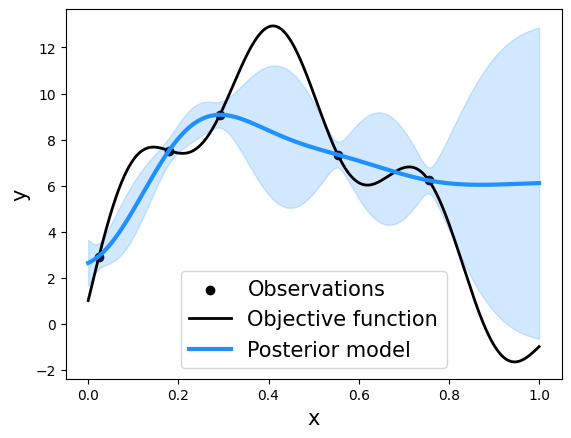

In [4]:
X = torch.linspace(bounds[0, 0], bounds[1, 0], 1000, **tkwargs)
mean_fX = model.posterior(X).mean.squeeze(-1).detach().numpy()
std_fX = torch.sqrt(model.posterior(X).variance).squeeze(-1).detach().numpy()

plt.scatter(train_X, train_Y, color="k", label="Observations")
plt.plot(X, f(X), color="k", linewidth=2, label="Objective function")
plt.plot(X, mean_fX, color="dodgerblue", linewidth=3, label="Posterior model")
plt.fill_between(
    X, (mean_fX + 3 * std_fX), (mean_fX - 3 * std_fX), alpha=0.2, color="dodgerblue"
)
plt.xlabel("x", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.legend(fontsize=15)
plt.show()

To compute the information-theoretic acquisition functions, we first need to get some Monte Carlo samples of the optimal inputs and outputs. The method `sample_optimal_points` generates `num_samples` approximate samples of the Gaussian process model and optimizes them sequentially using an optimizer. In the single-objective setting, the number of optimal points (`num_points`) should be set to one. For simplicitly, we consider optimization via random search. 

In [5]:
from botorch.acquisition.utils import get_optimal_samples

num_samples = 12

optimal_inputs, optimal_outputs = get_optimal_samples(
    model, bounds=bounds, num_optima=num_samples
)

We now initialize the information-theoretic acquisition functions. The PES can simply be initialized using just the optimal set of inputs. For the MES and JES acquisition function, we also have to specify the region of integration, which is $\{\mathbf{y}: \mathbf{y} \preceq \mathbb{Y}^*\}$ for a maximization problem. This is done by providing a Tensor of bounds, which is obtained via the method `compute_sample_box_decomposition`.

Note that for the MES algorithm, we use the multi-objective implementation `qLowerBoundMultiObjectiveMaxValueEntropySearch`, which implements all the estimation types into one acquisition function. BoTorch alreadys supports many other strategies to estimate the single-objective MES algorithms in `botorch.acquisition.max_value_entropy`, which is described in the other complementary notebooks.

In [6]:
from botorch.acquisition.joint_entropy_search import qJointEntropySearch
from botorch.acquisition.max_value_entropy_search import qLowerBoundMaxValueEntropy
from botorch.acquisition.predictive_entropy_search import qPredictiveEntropySearch

pes = qPredictiveEntropySearch(model=model, optimal_inputs=optimal_inputs)

# Here we use the lower bound estimates for the MES and JES
# Note that the single-objective MES interface is slightly different,
# as it utilizes the Gumbel max-value approximation internally and
# therefore does not take the max values as input.
mes_lb = qLowerBoundMaxValueEntropy(
    model=model,
    candidate_set=torch.rand(1000, 1),
)
jes_lb = qJointEntropySearch(
    model=model,
    optimal_inputs=optimal_inputs,
    optimal_outputs=optimal_outputs,
    estimation_type="LB",
)

To illustrate the acquisition functions, we evaluate it over the whole input space and plot it. As described in [3], the JES should be an upper bound to both the PES and MES, although the estimates might not be.

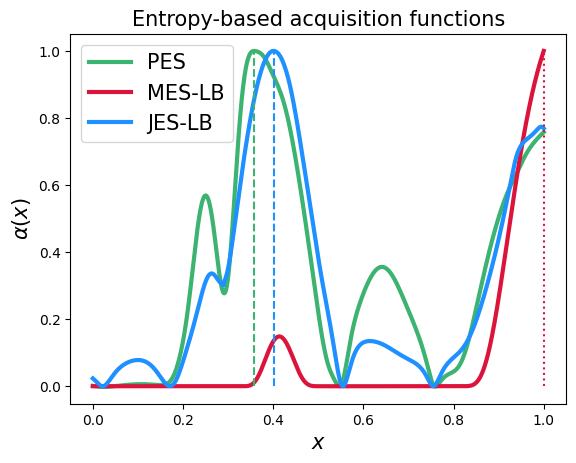

In [7]:
# the acquisition function call takes a three-dimensional tensor
fwd_X = X.unsqueeze(-1).unsqueeze(-1)

# make the acquisition functions live on the same scale
scale_acqvals = True

pes_X = pes(fwd_X).detach().numpy()
mes_lb_X = mes_lb(fwd_X).detach().numpy()
jes_lb_X = jes_lb(fwd_X).detach().numpy()

if scale_acqvals:
    pes_X = pes_X / pes_X.max()
    mes_lb_X = mes_lb_X / mes_lb_X.max()
    jes_lb_X = jes_lb_X / jes_lb_X.max()

plt.plot(X, pes_X, color="mediumseagreen", linewidth=3, label="PES")
plt.plot(X, mes_lb_X, color="crimson", linewidth=3, label="MES-LB")
plt.plot(X, jes_lb_X, color="dodgerblue", linewidth=3, label="JES-LB")

plt.vlines(
    X[pes_X.argmax()], 0, 1, color="mediumseagreen", linewidth=1.5, linestyle="--"
)
plt.vlines(X[mes_lb_X.argmax()], 0, 1, color="crimson", linewidth=1.5, linestyle=":")
plt.vlines(
    X[jes_lb_X.argmax()], 0, 1, color="dodgerblue", linewidth=1.5, linestyle="--"
)
plt.legend(fontsize=15)
plt.xlabel("$x$", fontsize=15)
plt.ylabel(r"$\alpha(x)$", fontsize=15)
plt.title("Entropy-based acquisition functions", fontsize=15)
plt.show()

To maximize the acquisition function in a standard Bayesian optimization loop, we can use the standard optimization routines. Note that the PES acquisition function might not be differentiable since some operations that may arise during expectation propagation are not differentiable. Therefore, we use a finite difference approach to optimize this acquisition function.

In [8]:
from botorch.optim import optimize_acqf

# Use finite difference for PES
candidate, acq_value = optimize_acqf(
    acq_function=pes,
    bounds=bounds,
    q=1,
    num_restarts=4,
    raw_samples=256,
    options={"with_grad": False},
)
print("PES: candidate={}, acq_value={}".format(candidate, acq_value))

candidate, acq_value = optimize_acqf(
    acq_function=mes_lb,
    bounds=bounds,
    q=1,
    num_restarts=4,
    raw_samples=256,
)
print("MES-LB: candidate={}, acq_value={}".format(candidate, acq_value))

candidate, acq_value = optimize_acqf(
    acq_function=jes_lb,
    bounds=bounds,
    q=1,
    num_restarts=4,
    raw_samples=256,
)
print("JES-LB: candidate={}, acq_value={}".format(candidate, acq_value))

PES: candidate=tensor([[0.3580]], dtype=torch.float64), acq_value=0.19717538198659618
MES-LB: candidate=tensor([[1.]], dtype=torch.float64), acq_value=0.021555580199623052
JES-LB: candidate=tensor([[0.4009]], dtype=torch.float64), acq_value=0.5871791655707925


# 2. Multi-objective batch example 

In this section, we illustrate a simple multi-objective example. First we generate some data and fit the model.

In [9]:
from botorch.acquisition.multi_objective.utils import (
    compute_sample_box_decomposition,
    random_search_optimizer,
    sample_optimal_points,
)
from botorch.test_functions.multi_objective import ZDT1

d = 4
M = 2
n = 8

if SMOKE_TEST:
    q = 2
else:
    q = 4

In [10]:
problem = ZDT1(dim=d, num_objectives=M, noise_std=0, negate=True)
bounds = problem.bounds.to(**tkwargs)

train_X = draw_sobol_samples(bounds=bounds, n=n, q=1, seed=123).squeeze(-2)
train_Y = problem(train_X)

model = fit_model(train_X=train_X, train_Y=train_Y, num_outputs=M)

We now obtain Monte Carlo samples of the optimal inputs and outputs.

In [11]:
num_pareto_samples = 8
num_pareto_points = 8

# We set the parameters for the random search
optimizer_kwargs = {
    "pop_size": 500,
    "max_tries": 10,
}

ps, pf = sample_optimal_points(
    model=model,
    bounds=bounds,
    num_samples=num_pareto_samples,
    num_points=num_pareto_points,
    optimizer=random_search_optimizer,
    optimizer_kwargs=optimizer_kwargs,
)

We initialize the acquisition functions as before.

In [12]:
from botorch.acquisition.multi_objective.joint_entropy_search import (
    qLowerBoundMultiObjectiveJointEntropySearch,
)
from botorch.acquisition.multi_objective.max_value_entropy_search import (
    qLowerBoundMultiObjectiveMaxValueEntropySearch,
)
from botorch.acquisition.multi_objective.predictive_entropy_search import (
    qMultiObjectivePredictiveEntropySearch,
)

pes = qMultiObjectivePredictiveEntropySearch(model=model, pareto_sets=ps)

# Compute the box-decomposition
hypercell_bounds = compute_sample_box_decomposition(pf)

# # Here we use the lower bound estimates for the MES and JES
mes_lb = qLowerBoundMultiObjectiveMaxValueEntropySearch(
    model=model,
    hypercell_bounds=hypercell_bounds,
    estimation_type="LB",
)

jes_lb = qLowerBoundMultiObjectiveJointEntropySearch(
    model=model,
    pareto_sets=ps,
    pareto_fronts=pf,
    hypercell_bounds=hypercell_bounds,
    estimation_type="LB",
)

We now optimize the batch acquistion functions. For the batch PES, we optimize the batch acquisition function directly. Whereas for the MES and JES we use a sequential optimization strategy.

In [13]:
%%time
# Use finite difference for PES. This may take some time
candidates, acq_values = optimize_acqf(
    acq_function=pes,
    bounds=bounds,
    q=q,
    num_restarts=4,
    raw_samples=512,
    options={"with_grad": False},
)
print("PES: \ncandidates={}".format(candidates))

# Sequentially greedy optimization
candidates, acq_values = optimize_acqf(
    acq_function=mes_lb,
    bounds=bounds,
    q=q,
    num_restarts=4,
    raw_samples=512,
    sequential=True,
)
print("MES-LB: \ncandidates={}".format(candidates))

PES: 
candidates=tensor([[0.0190, 0.5634, 0.0803, 0.1481],
        [0.0065, 0.0142, 0.3660, 0.1614],
        [0.0000, 1.0000, 1.0000, 0.0105],
        [0.0000, 0.2130, 0.8270, 0.0339]], dtype=torch.float64)


MES-LB: 
candidates=tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 0.1942, 0.6296, 0.0000],
        [0.0000, 1.0000, 1.0000, 1.0000],
        [0.0000, 0.1100, 0.0000, 1.0000]], dtype=torch.float64)
CPU times: user 27.6 s, sys: 10.4 s, total: 38 s
Wall time: 28.1 s


In [14]:
# Sequentially greedy optimization
candidates, acq_values = optimize_acqf(
    acq_function=jes_lb,
    bounds=bounds,
    q=q,
    num_restarts=4,
    raw_samples=512,
    sequential=True,
)
print("JES-LB: \ncandidates={}".format(candidates))

JES-LB: 
candidates=tensor([[0.0000, 0.5914, 0.9009, 0.7954],
        [0.0000, 0.2358, 0.6617, 0.2675],
        [0.0000, 0.8903, 0.8872, 0.7459],
        [0.0000, 0.1396, 0.9941, 0.5595]], dtype=torch.float64)
